In [233]:
import numpy as np
import random
from pythreejs import *
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

For all, the only restrictions are that $\text{dir}$, or $\text{sph car}(\theta,\phi)$, is normalized. This can be ignored.

Distance Functions:

Back: $\frac{d}{\cos(\phi)}$

Left (+), Right (-): $\frac{\pm w}{2\sin(\phi)\cos(\theta)}-\frac{o}{\cos(\phi)}$

Top (+), Bottom (-): $\frac{\pm h}{2\sin(\phi)\sin(\theta)}-\frac{o}{\cos(\phi)}$

Their integrals, for future use:

Back: $d\ln|\tan(\phi)+\sec(\phi)|+C$


# Primitive elements

In [234]:
# create an instance of the line segment object
def ray(origin, direction, col):
  return Line(geometry=BufferGeometry(attributes={'position': BufferAttribute(array=np.array([origin, np.array(direction)]), normalized=False),}),material=LineBasicMaterial(color=col))

In [235]:
# create an instance of the box object
def point(position, col, size):
  return Points(geometry=BufferGeometry(attributes={"position": BufferAttribute(np.array([position]), normalized=False)}),
                material=PointsMaterial(color=col, size=size, sizeAttenuation=False))

In [236]:
# create an instance of the box object
def box(width, height, depth, position, col, col2, rot):
  box_geometry = BoxBufferGeometry(width=width, height=height, depth=depth)

  box_material = MeshPhysicalMaterial(color=col, transparent=True, opacity=0.5)
  box_mesh = Mesh(geometry=box_geometry, material=box_material)
  box_mesh.quaternion = tuple(Rotation.from_euler('xyz', rot, degrees=True).as_quat().tolist())
  
  wireframe_material = LineBasicMaterial(color=col2)
  wireframe = WireframeGeometry(box_geometry)
  wireframe_mesh = LineSegments(wireframe, wireframe_material)
  wireframe_mesh.quaternion = tuple(Rotation.from_euler('xyz', rot, degrees=True).as_quat().tolist())

  box_group = Group(children=[box_mesh, wireframe_mesh])
  box_group.position = position

  return box_group

# Helper fuctions

In [237]:
# takes two numpy arrays
def angle_between_vectors(a, b):
    return np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

In [238]:
# spherical to cartesian
def sph_car(theta, phi, r=1):
  x = r * np.sin(phi) * np.cos(theta)
  y = r * np.sin(phi) * np.sin(theta)
  z = r * np.cos(phi)
  return np.array([x, y, z])

In [239]:
def car_sph(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arccos(z / r)
    theta = np.arctan2(y, x)
    return theta, phi

In [240]:
# entry and exit points for a ray through an axis-aligned box
def intersect_ray_box(ray_origin, ray_direction, box_min, box_max):
    tnear = float('-inf')
    tfar = float('inf')

    for i in range(3):
        if ray_direction[i] == 0:
            if ray_origin[i] < box_min[i] or ray_origin[i] > box_max[i]:
                return None, None
        else:
            t1 = (box_min[i] - ray_origin[i]) / ray_direction[i]
            t2 = (box_max[i] - ray_origin[i]) / ray_direction[i]

            if t1 > t2:
                t1, t2 = t2, t1

            if t1 > tnear:
                tnear = t1

            if t2 < tfar:
                tfar = t2

            if tnear > tfar:
                return None, None

            if tfar < 0:
                return None, None

    return ray_origin + ray_direction * tnear, ray_origin + ray_direction * tfar

In [241]:
# [four np.array]=>[bool,entry,exit]
#I think the issue with this is that there is some kind of tiny error in the alignment with the z axis. This causes the ray to JUST miss. 
def non_aligned_box_hit(position, size, ray_start, ray_direction):
    vector = ray_direction - ray_start                      # ray converted to vector by moving to origin
    point = position - ray_start                            # box position moved back accordingly
    u = point/np.linalg.norm(point)                   # unit position of the box: project box pos onto unit sphere
    z = np.array([0,0,1])                                   # axis we want to align the box to
    r = np.cross(u,z)/np.linalg.norm(np.cross(u,z))         # unit axis of rotation
    a = np.arccos(np.dot(u,z))                              # angle of rotation
    #-------------------------------------------------------#
    r_x, r_y, r_z = r
    i = np.eye(3)                                           # Identity matrix
    r_cross = np.array([                                    # Skew-symmetric matrix [r]_x
        [0, -r_z, r_y],
        [r_z, 0, -r_x],
        [-r_y, r_x, 0]
    ])
    r_cross_squared = np.array([                            # Skew-symmetric matrix squared [r]_x^2
        [-(r_y**2 + r_z**2), r_x * r_y, r_x * r_z],
        [r_x * r_y, -(r_x**2 + r_z**2), r_y * r_z],
        [r_x * r_z, r_y * r_z, -(r_x**2 + r_y**2)]
    ])
    rot_mat = i + np.sin(a) * r_cross + (1 - np.cos(a)) * r_cross_squared
    #-------------------------------------------------------#
    vector_rotated = rot_mat @ vector                       # apply rotation to vector
    point_aligned = rot_mat @ point                         # apply rotation to point
    #-------------------------------------------------------#
    w, h, d = size
    box_min = np.array([-w / 2, -h / 2, np.dot(point_aligned,z) - d / 2])
    box_max = np.array([w / 2, h / 2, np.dot(point_aligned,z) + d / 2]) 
    #-------------------------------------------------------#
    en, ex = intersect_ray_box(np.array([0,0,0]), vector_rotated, box_min, box_max)
    if en is not None and ex is not None:
        return True, np.linalg.inv(rot_mat) @ en + ray_start, np.linalg.inv(rot_mat) @ ex + ray_start
    else:
        return False, 0, 0

In [242]:
# relationship between enery level and number of photons
def γ_num_by_MeV(MeV):
  return 1/(MeV+0.1)

In [243]:
# relationship between enery level and angle
def MeV_by_φ(MeV):
  return 5/(MeV**0.5+0.5)-4/3

In [244]:
# selects a random photon energy in the range of interest
def random_energy_level(MeV_range):
  n1 = random.random() * (MeV_range[1] - MeV_range[0]) + MeV_range[0]
  n2 = random.uniform(0,γ_num_by_MeV(MeV_range[0]))

  if n2 > γ_num_by_MeV(n1):
    return -1
  else:
    return n1

In [245]:
# takes a range of MeV we're interested in and outputs a corresponding θ and φ
def dir_from_γ_energy_range(range):
  MeV = random_energy_level(range)
  if MeV > 0:
    return random.uniform(0,2*np.pi), MeV_by_φ(MeV)
  else:
    return -1, -1

In [246]:
def angles_to_hemipoint(theta,phi):
    phi = np.cos(phi)
    return np.array([np.sqrt(1 - phi**2) * np.cos(theta), np.sqrt(1 - phi**2) * np.sin(theta), phi])

In [247]:
# calculate uniform-distribution average distance through target
def average_ray_length_uniform(samples):
    data = np.array([])

    for i in range(samples):
        theta = random.uniform(0,2*np.pi)
        phi = (random.random() + np.cos(phi_max)) % 1
        dir = angles_to_hemipoint(theta,phi)
        en, ex = intersect_ray_box(np.array([0, 0, 0]), dir, box_min, box_max)
        if en is not None and ex is not None:
            data = np.append(data, np.linalg.norm(en - ex))

    return np.mean(data)

In [248]:
# returns the depth at which γd reaction occurs in range (0,target depth)
def γ_depth(d):
    r = d*random.random()
    fr = 1/(2*r+1)
    r2 = random.random()
    if r2 <= fr:
        return r
    else:
        return γ_depth(d)

In [249]:
# returns the angle at which a neutron is ejected following γd reaction
def n_angle_CM(min,max):
    r = random.uniform(min,max)
    fr = 1/(r**2+1)
    r2 = random.random()
    if r2 <= fr:
        return r+np.pi/2
    else:
        return n_angle_CM(min,max)

In [250]:
def n_dir(γ,mn,b,q,origin,depth):
    theta = n_angle_CM(-2*np.pi,2*np.pi)
    dir = np.array([q*np.cos(theta),0,b*γ**2*mn+γ*q*np.sin(theta)])
    collision_depth = γ_depth(depth)
    poc = np.array([0,0,origin+collision_depth])
    return (poc,dir)

In [251]:
def np_momentum(γ,v,c,pγz,md,mp,mn):
    EγCM = γ*pγz*(1-v/c)
    pdCM = -v
    a = EγCM + np.sqrt(md**2+pdCM**2)
    return np.sqrt((a**2+mn**2-mp**2)**2-4*a**2*mn**2)/(2*a)

# Interface

In [252]:
# parameters (θ is azimuthal, φ is polar)
origin = 10                                                                 # along z: distance from origin
# target dimensions
width = 0.3                                                                 # along x
height = 2.5                                                                # along y
depth = 3.8                                                                 # along z
# detctor dimensions
width_d = 5                                                                 # along x
height_d = 20                                                               # along y
depth_d = 10                                                                # along z
# parameters of the colliding particles
pγz = 400                                                                   # z-momentum of the photon
mp = 938.28                                                                 # mass of the proton
mn = 939.57                                                                 # mass of the neutron
md = 1875.61                                                                # mass of the deuteron
c = 1                                                                       # speed of light normalized
v = pγz/(pγz+md*c)                                                          # velocity of the CM frame
γ = 1/np.sqrt(1-v**2/c**2)                                                  # Lorentz factor
pn = np_momentum(γ,v,c,pγz,md,mp,mn)                                        # momentum of the proton and neutron in CM frame
neutron_path = n_dir(γ,mn,v/c,pn,origin,depth)                              # tuple point of collision, direction vector
# misc
box_min = np.array([-width / 2, -height / 2, origin])                       # minimum point along target box
box_max = np.array([width / 2, height / 2, depth + origin])                 # maximum point along target box 
phi_max = np.arctan(np.sqrt((height/2)**2 + (width/2)**2) / origin)         # maximum polar coordinate along target box

In [253]:
# params for histogram
samples = 100000                                                            # number of rays tried
bins = 100                                                                  # number of bins for successful rays to land in

# Rendering stuff

In [254]:
# histogram
data = np.array([])
phi_values = []
theta_values = []
data_w_misses = np.array([])
phi_values_w = []
theta_values_w = []

for i in range(samples):
    theta = random.uniform(0,2*np.pi)
    phi = (random.random() + np.cos(phi_max)) % 1
    dir = angles_to_hemipoint(theta, phi)
    en, ex = intersect_ray_box(np.array([0, 0, 0]), dir, box_min, box_max)
    if en is not None and ex is not None:
        data = np.append(data, np.linalg.norm(en - ex))
        data_w_misses = np.append(data_w_misses, np.linalg.norm(en - ex))
        phi_values.append(phi)
        theta_values.append(theta)
    else:
        data_w_misses = np.append(data_w_misses, 0)
    phi_values_w.append(phi)
    theta_values_w.append(theta)

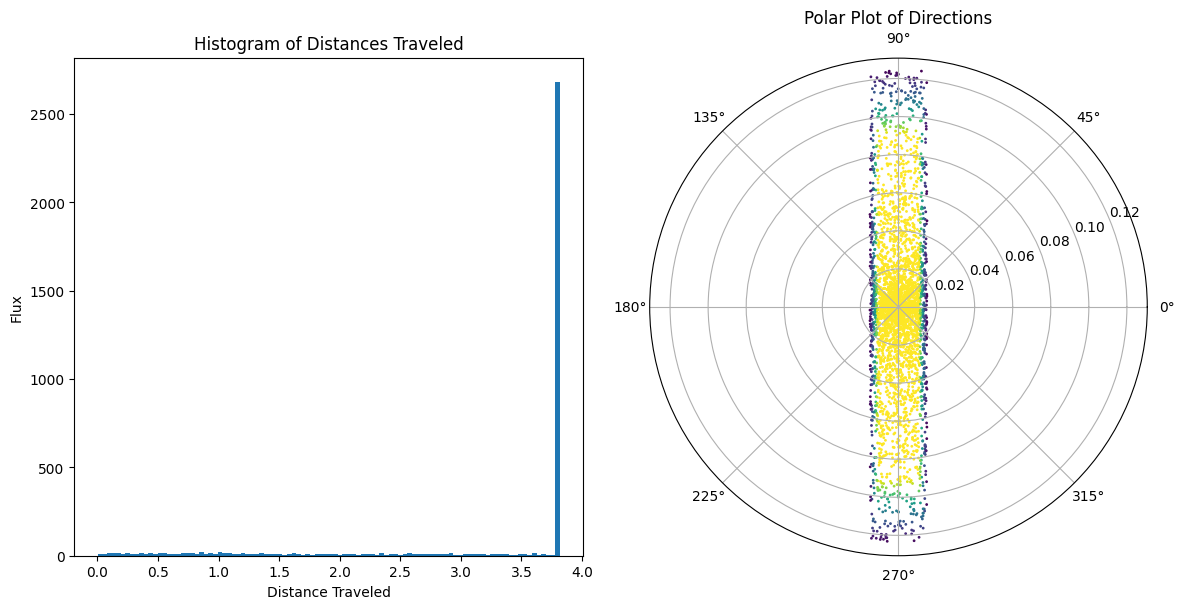

Mean Distance Traveled: 3.223956587760507


In [259]:
# Plot histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data, bins=bins)
plt.xlabel('Distance Traveled')
plt.ylabel('Flux')
plt.title('Histogram of Distances Traveled')

norm = colors.Normalize(vmin=0, vmax=depth)
cmap = cm.viridis

point_colors = cmap(norm(data))

# Plot polar coordinates
plt.subplot(1, 2, 2, projection='polar')
plt.scatter(np.array(theta_values), np.array(np.mod(phi_values,2*np.pi)), s=1, c=point_colors)
plt.title('Polar Plot of Directions')

plt.tight_layout()
plt.show()

# Print mean of the data
print("Mean Distance Traveled:", np.mean(data))

In [256]:
# UI rendering
target_box = box(width, height, depth, (0, 0, depth / 2 + origin), 'red', '#ff7070', [0,0,0])
d_pos = lambda a, r: (-r*100*np.sin(np.deg2rad(a)), 0, depth / 2 + origin - r*100*np.cos(np.deg2rad(a)))
d_90 = box(width_d, height_d, depth_d, d_pos(90,20), 'green', '#69f069', [0,90+90,0])
d_135 = box(width_d, height_d, depth_d, d_pos(135,20), '#645cf2', '#9f9af5', [0,135+90,0])
d_155 = box(width_d, height_d, depth_d, d_pos(155,12.8), '#fac516', '#fadc7a', [0,155+90,0])

origin_point = point([0, 0, 0], 'white', 4)

ah = AxesHelper(size=1)

scene = Scene(children=[target_box, origin_point, ah, d_90, d_135, d_155])
scene.background = '#141414'

# scene.add(ray())

lights = [
    DirectionalLight(color='white', intensity=3, position=[0, 200, 0]),
    DirectionalLight(color='white', intensity=3, position=[100, 200, 100]),
    DirectionalLight(color='white', intensity=3, position=[-100, -200, -100])
]
for light in lights:
    scene.add(light)

camera = PerspectiveCamera(position=[10, 10, 10], up=[0, 1, 0], aspect=2, far=500000, children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])


display(Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)], antialias=True, width=2000, height=1000))

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.5, positio…

hit prob at photon energy 400 MeV: 0.18


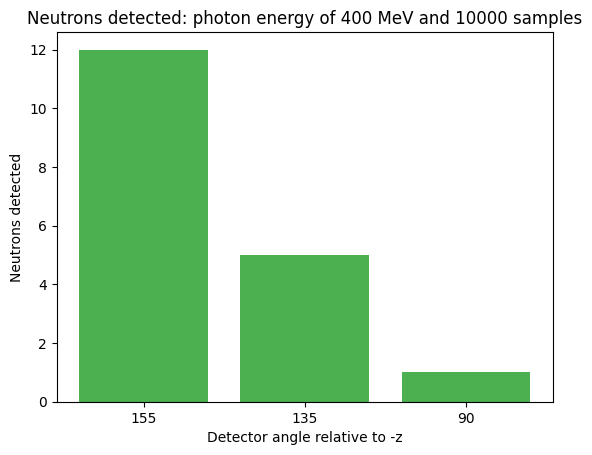

In [257]:
detector_hits = [0,0,0]
labels = ['155', '135', '90']
neutrons = 10000

for i in range(neutrons):
    neutron_path = n_dir(γ,mn,v/c,pn,origin,depth)
    
    if non_aligned_box_hit(np.array(d_pos(155,12.8)),np.array([width_d, height_d, depth_d]),neutron_path[0], neutron_path[0]+neutron_path[1])[0]:
        detector_hits[0] += 1
    elif non_aligned_box_hit(np.array(d_pos(135,20)),np.array([width_d, height_d, depth_d]),neutron_path[0], neutron_path[0]+neutron_path[1])[0]:
        detector_hits[1] += 1
    elif non_aligned_box_hit(np.array(d_pos(90,20)),np.array([width_d, height_d, depth_d]),neutron_path[0], neutron_path[0]+neutron_path[1])[0]:
        detector_hits[2] += 1

print(f"hit prob at photon energy {pγz} MeV: {100*sum(detector_hits)/neutrons}")
plt.bar(labels, detector_hits, color='#4CAF50')
plt.title(f"Neutrons detected: photon energy of {pγz} MeV and {neutrons} samples")
plt.xlabel("Detector angle relative to -z")
plt.ylabel("Neutrons detected")
plt.show()
